In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression

In [2]:
CNN_oof = np.load('../input/cnn-model-v5/CNN_oof_predictions.npy')
LGBM_oof = np.load('../input/lgbm-model/LGBM_oof_predictions.npy')
LSTM_oof = np.load('../input/lstm-final-model-run-4/LSTM_oof_predictions.npy')

for n in range(1,6,1):
    if n == 1:
        y_true = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = y_true.reshape((y_true.shape[0],1))
    else:
        y_fold = np.load(f'../input/f{n}-final/Fold{n}_val_label.npy')
        y_true = np.row_stack([y_true, y_fold.reshape((y_fold.shape[0], 1))])

In [3]:
oof_labels = np.column_stack((CNN_oof, LGBM_oof, LSTM_oof, y_true))

In [4]:
X = oof_labels[:,:-1]
y = oof_labels[:,-1]

LR = LinearRegression(fit_intercept=False)
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [5]:
AVG_oof = (CNN_oof * LR.coef_[0] + LGBM_oof * LR.coef_[1] + LSTM_oof * LR.coef_[2]) / (sum(LR.coef_))
ensemble_rocauc = roc_auc_score(y_true, AVG_oof)
cnn_rocauc = roc_auc_score(y_true, CNN_oof)
lgbm_rocauc = roc_auc_score(y_true, LGBM_oof)
lstm_rocauc = roc_auc_score(y_true, LSTM_oof)

print(f'Ensemble ROCAUC  : {ensemble_rocauc:.4f}')
print(f'CNN ROCAUC       : {cnn_rocauc:.4f}')
print(f'LGBM ROCAUC      : {lgbm_rocauc:.4f}')
print(f'LSTM ROCAUC      : {lstm_rocauc:.4f}')
print(f'CNN Cooeficient  : {LR.coef_[0]:.8f}')
print(f'LGBM Cooeficient : {LR.coef_[1]:.8f}')
print(f'LSTM Cooeficient : {LR.coef_[2]:.8f}')

assert (len(AVG_oof[AVG_oof >= 1]) == 0) and (len(AVG_oof[AVG_oof <= 0]) == 0), 'OOF is not normalized.'

Ensemble ROCAUC  : 0.7537
CNN ROCAUC       : 0.7341
LGBM ROCAUC      : 0.7300
LSTM ROCAUC      : 0.7494
CNN Cooeficient  : 0.21416430
LGBM Cooeficient : 0.20759960
LSTM Cooeficient : 0.62418445


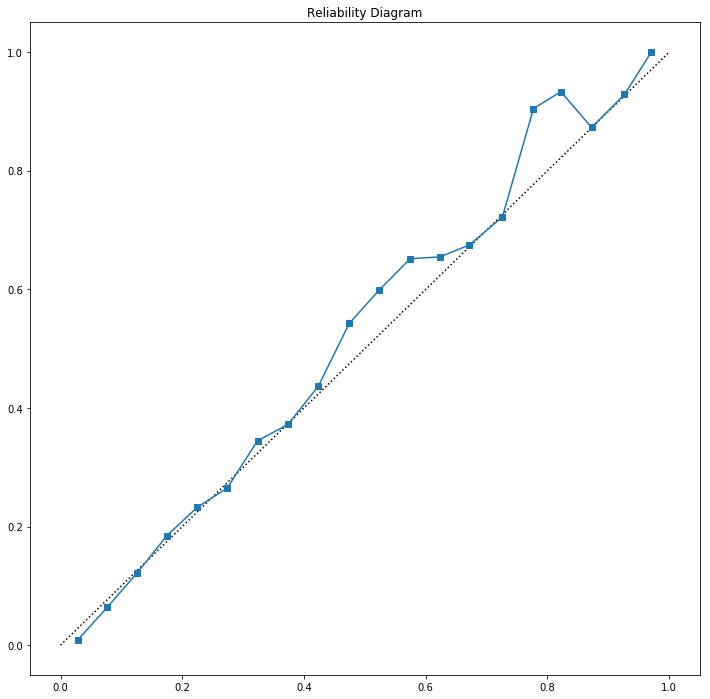

In [6]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, AVG_oof, n_bins =20)

plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'Ensemble Prediction')
plt.title(f'Reliability Diagram')
plt.show()